In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
import os
import shutil 

import random


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# распаковываем train (train_en + val_en)
!unzip "/content/drive/MyDrive/train_val_en.zip" -d "/content"

In [8]:
train_dir = 'train_en'
val_dir = 'val_en'

###  Разбиваем данные

In [4]:
class_names = ['1', '3', '6', '10', '20', '30']

data_root = '/content/'
for dir_name in ['train']:
    for class_name in class_names:
        os.makedirs(os.path.join(data_root, dir_name, class_name), exist_ok=True)

In [5]:
for class_name in class_names:
  for mode in ['train_en', 'val_en']:
    source_dir = os.path.join(data_root, mode, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(data_root, 'train', class_name, file_name))

In [ ]:
for class_name in class_names:
    source_dir = os.path.join(data_root + '/train_with_energy/', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
      if file_name[0] == '.':
        continue

      if i % 6 != 0:
        dest_dir = os.path.join(data_root + train_dir, class_name) 
      else:
        dest_dir = os.path.join(data_root + val_dir, class_name)
      shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

### Создаем загрузчики

In [9]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder('train', train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
train_dataloader.dataset.classes

['1', '10', '20', '3', '30', '6']

In [11]:
len(train_dataloader), len(train_dataset)

(838, 13404)

### Обучаем модели

In [14]:
SEED = 192
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [15]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    hystory_loss_train = []
    hystory_loss_val = []

    hystory_acc_train = []
    hystory_acc_val = []  
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
              hystory_loss_train.append(epoch_loss)
              hystory_acc_train.append(epoch_acc)
            else:
              hystory_loss_val.append(epoch_loss)
              hystory_acc_val.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val

### Модель v1 (SkipConnection)

In [16]:
class Net_v1(nn.Module):
    def __init__(self):
      super(Net_v1, self).__init__()
      self.c1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(3),
          nn.ReLU(), 
      )

      self.c2 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(3),
          nn.ReLU(),  
      )

      self.c3 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
          nn.BatchNorm2d(16),
          nn.MaxPool2d(kernel_size=3),
          nn.ReLU(),
         
      )

      self.c4 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(kernel_size=3),
          nn.ReLU(),
          
      )

      self.fc1 = nn.Sequential(
          nn.Linear(in_features=7200, out_features=1024),
          nn.ReLU()
      )

      self.fc2 = nn.Sequential(
          nn.Linear(in_features=1024, out_features=32),
          nn.ReLU()
      )

      self.fc3 = nn.Linear(in_features=32, out_features=6)
      
    def forward(self, x):
      # First block
      residual_1 = x
      out = self.c1(x)
      out += residual_1
      #print(out.shape)

      # Second block
      residual_2 = out
      out = self.c2(x)
      out += residual_2
      
      out = self.c3(out)
      out = self.c4(out)

      out = out.view(out.size(0), -1)
      #print(out.shape)
      out = self.fc1(out)
      out = self.fc2(out)
      out = self.fc3(out)
      return out

In [17]:
device = torch.device("cuda")
net_v1 = Net_v1()
net_v1 = net_v1.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net_v1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val =\
train_model(net_v1, loss, optimizer, scheduler, 10);

Epoch 0/9:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



train Loss: 0.5669 Acc: 0.7911



val Loss: 0.2502 Acc: 0.9728
Epoch 1/9:



train Loss: 0.1559 Acc: 0.9830



val Loss: 0.1259 Acc: 0.9964
Epoch 2/9:



train Loss: 0.0724 Acc: 0.9941



val Loss: 0.0716 Acc: 0.9955
Epoch 3/9:



train Loss: 0.0442 Acc: 0.9944



val Loss: 0.0502 Acc: 0.9969
Epoch 4/9:



train Loss: 0.0363 Acc: 0.9963



val Loss: 0.0487 Acc: 0.9969
Epoch 5/9:



train Loss: 0.0344 Acc: 0.9966



val Loss: 0.0482 Acc: 0.9969
Epoch 6/9:



train Loss: 0.0344 Acc: 0.9957



val Loss: 0.0470 Acc: 0.9969
Epoch 7/9:



train Loss: 0.0335 Acc: 0.9961



val Loss: 0.0472 Acc: 0.9969
Epoch 8/9:



train Loss: 0.0330 Acc: 0.9966



val Loss: 0.0452 Acc: 0.9969
Epoch 9/9:



train Loss: 0.0344 Acc: 0.9962



val Loss: 0.0453 Acc: 0.9969


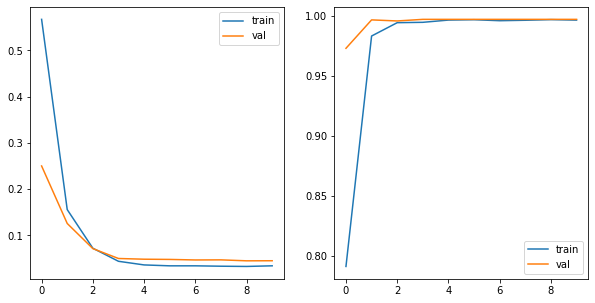

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(hystory_loss_train, label='train')
ax1.plot(hystory_loss_val, label='val')
ax1.legend()

# валидация не показательна
ax2.plot(hystory_acc_train, label='train')
ax2.plot(hystory_acc_val, label='val')
ax2.legend()

In [20]:
torch.save(net_v1, '/content/drive/MyDrive/skipconnection_energy.pt')

### Предсказание на тесте и submission

In [26]:
from collections import defaultdict

In [ ]:
# распаковываем test_public
!unzip "/content/drive/MyDrive/public_test.zip" -d "/content/test"

# распаковываем test_private
!unzip "/content/drive/MyDrive/private_test.zip" -d "/content/test"

In [22]:
test_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [23]:
test_dir = 'test'
data_root = '/content/drive/MyDrive/'
test_dataset = torchvision.datasets.ImageFolder(test_dir, test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=16)

In [27]:
dict_pred = defaultdict(list)
file_names = []
for line in test_dataset.imgs:
  file_names.append(str(line).split('/')[-1].split('.')[0])

dict_pred["id"] = file_names

In [28]:
%%time
net_v1.to('cuda').eval()
with torch.no_grad():
    for i, (img, name) in enumerate(tqdm(test_loader)):
        img = img.to('cuda')
        outputs = net_v1(img)
        _, predicted = torch.max(outputs.data, dim=1)
        predicted = list(map(int, predicted.cpu()))
        dict_pred["regression_predictions"].extend(predicted)


CPU times: user 1min 1s, sys: 3.96 s, total: 1min 5s
Wall time: 1min 15s


In [29]:
data_frame = pd.DataFrame(dict_pred, columns=["id", "regression_predictions"])
data_frame['regression_predictions'] = data_frame.regression_predictions.replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})

data_frame.head(10)

,id,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,10.0
1,0005564c011259402dcb6e3beb6e64d285124fa0,30.0
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,20.0
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1.0
4,000eb12def5371089743dcfe401a8e399f5883fc,20.0
5,0010e112a8aaadba9b9407b781a98d8dee639082,20.0
6,00149e230533e9a0d186560062c6cbafe3290bf3,10.0
7,0017ba314c74d87184e778b50b34173c4c8810dc,6.0
8,002721e996690a2d080ac7cacd8436a869cdfb4a,1.0
9,0029f7d7eb2379475341f4eea718456ed897ae24,30.0


In [30]:
data_frame.to_csv(data_root + 'reg_v3.csv', index=False, header=True)